# Fashion MNIST Dataset ML

This dataset contains images of 10 different types of clothing. The goal is to build a classifier that can distinguish between the different types.

## Imports

In [21]:
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_datasets import load, show_examples

## Loading the Dataset

Number of Training Examples: 60000
Number of Testing Examples: 10000
Sample Images:


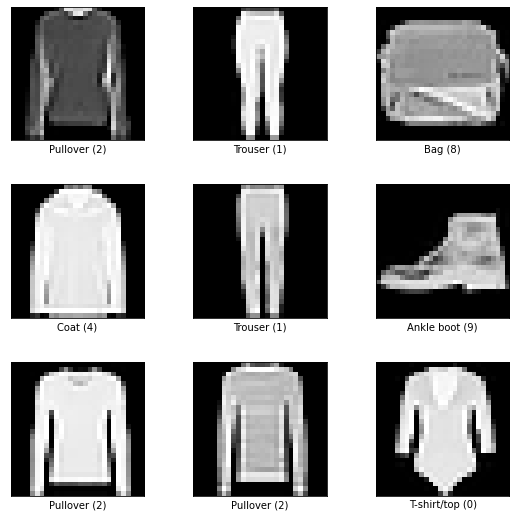

In [39]:
(train_ds, test_ds), ds_info = load('fashion_mnist', split=['train', 'test'], as_supervised=True, with_info=True)
print(f'Number of Training Examples: {ds_info.splits["train"].num_examples}')
print(f'Number of Testing Examples: {ds_info.splits["test"].num_examples}')
print('Sample Images:')
fig = show_examples(train_ds, ds_info)


### Helper Function to Save our Best Model

In [49]:
def save_best_model(model, test_ds):
    try:
        saved_model = tf.keras.models.load_model('models\\CNN')
    except:
        saved_model = None

    if saved_model:
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['sparse_categorical_accuracy'] > saved_model_metrics['sparse_categorical_accuracy']:
            model.save('models\\CNN')
    else:
        model.save('models\\CNN')

## Preparing the Dataset

In [41]:
def cnn_normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    return image, label

batch_size = 32

train_ds = train_ds.map(cnn_normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(1)

test_ds = test_ds.map(cnn_normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(1)


## Building the Model

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 4, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 4, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

## Training the Model

In [43]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=test_ds
)

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6704 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.4377 - val_sparse_categorical_accuracy: 0.8434
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3757 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.3790 - val_sparse_categorical_accuracy: 0.8595
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8748 - val_loss: 0.3775 - val_sparse_categorical_accuracy: 0.8678
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3147 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.3815 - val_sparse_categorical_accuracy: 0.8692
Epoch 5/100
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2950 - sparse_categorical_accuracy: 0.8904 - val_loss: 0.3388 - val_sparse_categorical_accuracy: 0.8768
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2806 -

## Plot the Training Results

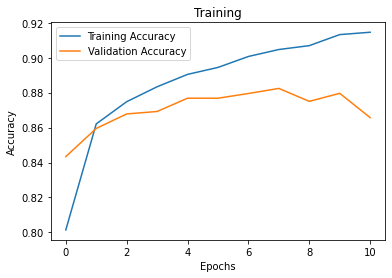

In [44]:
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Save our Best Model

In [45]:
save_best_model(model, test_ds)

313/313 [==============================] - 1s 2ms/step - loss: 0.3427 - sparse_categorical_accuracy: 0.8824
INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


## Using the Hyperparameter Tuner

In [73]:
def build_model(hp):
    model = tf.keras.Sequential()
    first_layer_filters = hp.Choice('first_layer_filters', [32, 64, 128])
    first_layer_kernel = hp.Choice('first_layer_kernel', [3, 4, 5])
    model.add(tf.keras.layers.Conv2D(first_layer_filters, first_layer_kernel, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPool2D())
    second_layer_filters = hp.Choice('second_layer_filters', [32, 64, 128])
    second_layer_kernel = hp.Choice('second_layer_kernel', [3, 4, 5])
    model.add(tf.keras.layers.Conv2D(second_layer_filters, second_layer_kernel, activation='relu'))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Flatten())
    if hp.Choice('extra_dense_layer', [True, False]):
        model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10))
    learning_rate = hp.Choice('learning_rate', [0.005, 0.001, 0.0005, 0.0001])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )
    return model

with open('../../../secrets.json') as f:
    secrets = json.load(f)
    hp_tuning_directory = secrets['hp_tuning_directory']
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=3,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    restore_best_weights=True
)
tuner = kt.Hyperband(build_model, 'val_sparse_categorical_accuracy', 25, directory=hp_tuning_directory, hyperband_iterations=2, overwrite=True, project_name='hp_tuning')
tuner.search(train_ds, callbacks=[early_stopping_callback], validation_data=test_ds)
tuner.results_summary(num_trials=3) # Show only the 3 best trials
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

Trial 60 Complete [00h 01m 02s]
val_sparse_categorical_accuracy: 0.8903999924659729

Best val_sparse_categorical_accuracy So Far: 0.90829998254776
Total elapsed time: 00h 48m 34s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in .\hyperparameter_tuning
Showing 3 best trials
Objective(name='val_sparse_categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
first_layer_filters: 32
first_layer_kernel: 4
second_layer_filters: 128
second_layer_kernel: 3
extra_dense_layer: 1
learning_rate: 0.0005
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 9d6553642250275ede72e3d5d2a7d6b4
Score: 0.90829998254776
Trial summary
Hyperparameters:
first_layer_filters: 64
first_layer_kernel: 5
second_layer_filters: 128
second_layer_kernel: 5
extra_dense_layer: 1
learning_rate: 0.0005
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: d8312c325d59357abdfefa118d896bdd
Score: 0.9060999751091003
Trial summary
Hyperparameters:
first_layer_filters: 128
first_layer_kernel: 3
second_layer_filters: 128
second_layer_kernel: 5
extra_dense_layer: 1
learning_rate: 0.0005
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tun

## Saving the Best Model

In [74]:
save_best_model(best_model, test_ds)

313/313 [==============================] - 1s 2ms/step - loss: 0.3018 - sparse_categorical_accuracy: 0.9083
INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


As can be seen above, the best classifier currently achieves 90.83% accuracy on the test set